# Introducción


Para procesamiento de los datos por los modelos para la detección de reseñas falsas, usaremos el conjunto de datos proporcionados por la plataforma <a href="https://www.yelp.es">Yelp</a>, conocidos como <A Href="https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset/data">Yelp Dataset</A>, este dataset es un conjunto de datos público que la empresa __Yelp__ pone a disposición para fines académicos, educativos y de investigación personal.  En esencia, la colección de datos son un subconjunto de datos extraídos de la plataforma Yelp y "anonimizado" hasta cierto punto.

<a href="https://business.yelp.com/data/resources/open-dataset/"><img src=https://business.yelp.com/wp-content/themes/yelp-b2b/assets/branding/yelp-data-logo.svg></a>

El DataSet de Yelp se compone de varios conjuntos de datos (ficheros). Para los fines de este trabajo, los más relevantes y que constituyen la fuente principal de información son los siguientes:

1. Business (Establecimientos): Contiene información detallada sobre los negocios, incluyendo su ID único, nombre, ubicación, categorías y otros atributos relevantes.
2. Reviews (Reseñas): Incluye el texto de las reseñas escritas por los usuarios, la puntuación otorgada, así como los identificadores del usuario y del negocio asociado.
3. User (Usuarios): Abarca información sobre los usuarios, como su ID, el número de reseñas que han contribuido, y otros datos demográficos o de actividad disponibles.

De estos tres conjuntos de datos primarios se extraerá toda la información necesaria para llevar a cabo las fases de exploración, selección y evaluación de los datos, y para la posterior aplicación y validación con cada uno de los modelos ML seleccionados.

# Librerías

In [1]:
import polars as pl
import pandas as pd
import pyarrow
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2') 
import seaborn as sns
import openai
from openai import OpenAI
import kagglehub

import json
import time
start_time_global = time.time()

import os
from dotenv import load_dotenv, find_dotenv 

color = '\033[1m\033[38;5;208m' 
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión polars: {pl.__version__}")
print(f"{color}Versión pyarrow: {pyarrow.__version__}")
print(f"{color}Versión numpy: {np.__version__}")
print(f"{color}Versión OpenAI: {openai.__version__}")

Versión pandas: 2.2.3
Versión polars: 1.27.1
Versión pyarrow: 16.1.0
Versión numpy: 2.0.1
Versión OpenAI: 1.76.2


In [2]:
#Cargar las variable de entorno
dotenv_path = find_dotenv()
carga_env = load_dotenv(dotenv_path=dotenv_path) 
if carga_env:
    print("Archivo .env encontrado y cargado exitosamente.")
else:
    print("No se encontró el archivo .env o no se pudo cargar.")

Archivo .env encontrado y cargado exitosamente.


# Datos

## Yelp dataset

El dataset se distribuye en varios ficheros en formato JSON (JavaScript Object Notation), cada uno representando un tipo diferente de información. Los componentes principales son:

* Información de Negocios (business.json): Detalles sobre los establecimientos listados en Yelp, como:
    * Nombre, dirección, coordenadas geográficas.
    * Categorías (restaurante, tienda, peluquería, etc.).
    * Atributos (acepta tarjetas, tiene Wi-Fi, bueno para grupos, etc.).
    * Horarios de apertura.
    * Puntuación media (estrellas).
    * Número de reseñas recibidas.

* Reseñas (review.json): El texto de las reseñas escritas por los usuarios, junto con metadatos como:
    * El texto completo de la reseña.
    * La calificación en estrellas otorgada (de 1 a 5).
    * La fecha de la reseña.
    * El ID del usuario que la escribió.
    * El ID del negocio reseñado.
    * Votos recibidos por la reseña (útil, divertida, genial - "useful, funny, cool").

* Información de Usuarios (user.json): Datos sobre los usuarios que escriben las reseñas:
    * ID del usuario.
    * Nombre (a menudo solo el primer nombre o un identificador).
    * Número total de reseñas escritas.
    * Tiempo siendo usuario de Yelp.
    * Lista de amigos (IDs de otros usuarios).
    * Puntuación media de las reseñas que ha escrito.
    * Número total de votos recibidos por sus reseñas.
    * Estado "Elite" (si lo tiene y en qué años).

* Check-ins (checkin.json): Registros de cuándo los usuarios han indicado ("hecho check-in") que han visitado un negocio.

* Consejos (tip.json): Textos cortos o consejos que los usuarios dejan sobre los negocios, distintos de las reseñas completas.

In [3]:
explicit_work_path = os.getenv('HOME_WORK')
# Fichero de reseñas
yelp_review_file_path = f'{explicit_work_path}yelp_academic_dataset_review.json'
# Fichero de Información de usuarios
yelp_user_file_path = f'{explicit_work_path}yelp_academic_dataset_user.json'
# Fichero Consejos
yelp_tip_file_path = f'{explicit_work_path}yelp_academic_dataset_tip.json'
# Fichero de Check-ins
yelp_chekin_file_path = f'{explicit_work_path}yelp_academic_dataset_checkin.json'
# Fichero de Información de negocios
yelp_business_file_path = f'{explicit_work_path}yelp_academic_dataset_business.json'

# Análisis Exploratorio

A continuación, se procede con un análisis exploratorio de datos (EDA), motivado principalmente por la naturaleza intrínseca y la heterogeneidad del conjunto de datos de Yelp. Este proceso se llevará a cabo siguiendo las siguientes etapas, consideradas clave para comprender a fondo los datos y preparar el terreno para el modelado:

1. Entender la estructura y complejidad de los datos:
    
    Cada uno de los conjuntos de datos puede estar integrado por múltiples archivos, como se observa en el caso del "Yelp Dataset". Por consiguiente, se estima pertinente proceder a su unificación con el objeto de simplificar la comprensión del corpus y ofrecer una perspectiva clara del volumen de los datos, el cual podrían comprender millones, miles o cientos de reseñas. Adicionalmente, es necesario verificar el formato y los tipos de datos, a modo de ejemplo, las estrellas podrían ser de carácter numérico, las fechas podrían exhibir formatos no válidos, o campos numéricos y podrían encontrarse almacenados como texto.

2. Evaluar la Calidad de los Datos:

    Es importante detectar valores faltantes y determinar la estrategia para su tratamiento, ya sea mediante su eliminación o imputación (ej. negocios que no tienen especificadas las horas).  Asimismo, detectar los errores, incosistencias o datos carentes de lógica (ej. una reseña con 0 estrellas si el rango es 1-5), lo que conduce principalmente a la detección de valores atípicos.

3. Descubrir Patrones e Insights Preliminares:

     El Análisis Exploratorio de Datos (EDA) en el contexto de reseñas requiere la evaluación de la distribución y la correlaciones entre el conjunto de los datos, ej. la longitud de las reseñas y/o el tono empleado, así como los patrones de comportamiento entre los usuarios con más votaciones y los usuarios promedio. Asimismo, el estudio de las variaciones temporales observadas en las reseñas y las valoraciones.

4. Guiar el Análisis Posterior y Modelado:

    El Análisis Exploratorio de Datos (EDA) es fundamental para formular hipótesis basadas en patrones, crear nuevas variables significativas (ingeniería de características), seleccionar modelos de Machine Learning adecuados según la distribución de los datos y validar los supuestos de los modelos estadísticos.

## Yelp dataset

A continuación, damos inicio al análisis EDA del conjunto de datos de Yelp.

### Estructura de los datos

#### Business - Establecimientos

In [4]:
print(f"Iniciando el procesamiento del archivo: {yelp_business_file_path}")
df_lazy_business_pl:pl.lazyframe.frame.LazyFrame = None
try:
    #Lee el archivo especificado y no lo carga inmediatamente en la memoria
    df_lazy_business_pl = pl.scan_ndjson(yelp_business_file_path)
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.")
    # Muestra las primeras 5 filas del DataFrame    
    display(df_lazy_business_pl.collect(engine='streaming').limit(25).head(2))

Iniciando el procesamiento del archivo: /home/teneo/fakereviews/yelp_academic_dataset_business.json
La operación fue exitosa.


business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
str,str,str,str,str,str,f64,f64,f64,i64,i64,struct[33],str,struct[7]
"""Pns2l4eNsfO8kk83dixA6A""","""Abby Rappoport, LAC, CMQ""","""1616 Chapala St, Ste 2""","""Santa Barbara""","""CA""","""93101""",34.426679,-119.711197,5.0,7,0,"{null,null,null,null,null,null,null,null,null,null,null,""True"",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}","""Doctors, Traditional Chinese M…",null
"""mpf3x-BjTdTEA3yCZrAYPw""","""The UPS Store""","""87 Grasso Plaza Shopping Cente…","""Affton""","""MO""","""63123""",38.551126,-90.335695,3.0,15,1,"{null,""True"",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}","""Shipping Centers, Local Servic…","{""0:0-0:0"",""8:0-18:30"",""8:0-18:30"",""8:0-18:30"",""8:0-18:30"",""8:0-14:0"",null}"


##### Ajuste de la calidad del dato
A continuación realizaremos la ordenación de las categorías en cada una de las celdas de forma alfabética, ya que esto facilitará cualquier explotación de la información.

In [14]:
start_time=time.time()
try:
    df_data_business_pl:pl.dataframe.frame.DataFrame = df_lazy_business_pl.collect(engine='streaming').with_columns(
        pl.col('categories')
        # 1. Dividir la cadena en una lista de strings, manejando nulos
        .str.split(',')
        # 2. Dentro de cada lista resultante, aplicar operaciones a cada elemento:
        .list.eval(
            # 2a. Quitar espacios en blanco al inicio/final de cada categoría
            pl.element().str.strip_chars()
        )
        # 3. Ordenar los elementos dentro de cada lista
        .list.sort()
        # 4. Unir los elementos de la lista de nuevo en una cadena, separados por ", "
        .list.join(', ')
    )
except Exception as e:
    print(f"An error occurred: {e}")
else: 
    print(f"La operación fue exitosa en {time.time()-start_time:.2f}seg")  
    # Muestra las primeras 5 filas del DataFrame  
    display(df_data_business_pl.limit(5).head(3))  

La operación fue exitosa en 1.74seg


business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
str,str,str,str,str,str,f64,f64,f64,i64,i64,struct[33],str,struct[7]
"""Pns2l4eNsfO8kk83dixA6A""","""Abby Rappoport, LAC, CMQ""","""1616 Chapala St, Ste 2""","""Santa Barbara""","""CA""","""93101""",34.426679,-119.711197,5.0,7,0,"{null,null,null,null,null,null,null,null,null,null,null,""True"",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}","""Acupuncture, Doctors, Health &…",null
"""mpf3x-BjTdTEA3yCZrAYPw""","""The UPS Store""","""87 Grasso Plaza Shopping Cente…","""Affton""","""MO""","""63123""",38.551126,-90.335695,3.0,15,1,"{null,""True"",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}","""Local Services, Mailbox Center…","{""0:0-0:0"",""8:0-18:30"",""8:0-18:30"",""8:0-18:30"",""8:0-18:30"",""8:0-14:0"",null}"
"""tUFrWirKiKi_TAnsVWINQQ""","""Target""","""5255 E Broadway Blvd""","""Tucson""","""AZ""","""85711""",32.223236,-110.880452,3.5,22,0,"{""{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}"",""True"",null,""False"",""False"",""False"",""False"",null,null,null,""2"",""False"",""False"",""False"",null,null,""False"",""u'no'"",""True"",""False"",""False"",null,""True"",null,null,null,null,null,null,null,null,null,null}","""Department Stores, Electronics…","{""8:0-22:0"",""8:0-22:0"",""8:0-22:0"",""8:0-22:0"",""8:0-23:0"",""8:0-23:0"",""8:0-22:0""}"


#### Chekin - Ha visitado el establecimiento

In [6]:
print(f"Iniciando el procesamiento del archivo: {yelp_chekin_file_path}")
df_data_chekin_pl = None
try:
    #Lee el archivo especificado y no lo carga inmediatamente en la memoria
    df_data_chekin = pl.scan_ndjson(yelp_chekin_file_path)
    #Lee los datos del archivo, los procesa y los almacena en un DataFrame
    df_data_chekin_pl = df_data_chekin.limit(25).collect(engine='streaming') 
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.")
    # Muestra las primeras 5 filas del DataFrame    
    display(df_data_chekin_pl.limit(25).head(5))

Iniciando el procesamiento del archivo: /home/teneo/fakereviews/yelp_academic_dataset_checkin.json
La operación fue exitosa.


business_id,date
str,str
"""---kPU91CF4Lq2-WlRu9Lw""","""2020-03-13 21:10:56, 2020-06-0…"
"""--0iUa4sNDFiZFrAdIWhZQ""","""2010-09-13 21:43:09, 2011-05-0…"
"""--30_8IhuyMHbSOcNWd6DQ""","""2013-06-14 23:29:17, 2014-08-1…"
"""--7PUidqRWpRSpXebiyxTg""","""2011-02-15 17:12:00, 2011-07-2…"
"""--7jw19RH9JKXgFohspgQw""","""2014-04-21 20:42:11, 2014-04-2…"


#### Review - Reseñas

In [5]:
print(f"Iniciando el procesamiento del archivo: {yelp_review_file_path}")
df_lazy_review_pl = None
try:
    #Lee el archivo especificado y no lo carga inmediatamente en la memoria
    df_lazy_review_pl = pl.scan_ndjson(yelp_review_file_path)
    #Lee los datos del archivo, los procesa y los almacena en un DataFrame
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.")

Iniciando el procesamiento del archivo: /home/teneo/fakereviews/yelp_academic_dataset_review.json
La operación fue exitosa.


Cargar todas las reseñas

In [6]:
start_time=time.time()
try:    
    df_data_review_pl = df_lazy_review_pl.collect(engine='streaming')
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print(f"La operación fue exitosa en {time.time()-start_time:.2f}seg")
    display(df_data_review_pl.head(5))

La operación fue exitosa en 4.30seg


review_id,user_id,business_id,stars,useful,funny,cool,text,date
str,str,str,f64,i64,i64,i64,str,str
"""KU_O5udG6zpxOg-VcAEodg""","""mh_-eMZ6K5RLWhZyISBhwA""","""XQfwVwDr-v0ZS3_CbbE5Xw""",3.0,0,0,0,"""If you decide to eat here, jus…","""2018-07-07 22:09:11"""
"""BiTunyQ73aT9WBnpR9DZGw""","""OyoGAe7OKpv6SyGZT5g77Q""","""7ATYjTIgM3jUlt4UM3IypQ""",5.0,1,0,1,"""I've taken a lot of spin class…","""2012-01-03 15:28:18"""
"""saUsX_uimxRlCVr67Z4Jig""","""8g_iMtfSiwikVnbP2etR0A""","""YjUWPpI6HXG530lwP-fb2A""",3.0,0,0,0,"""Family diner. Had the buffet. …","""2014-02-05 20:30:30"""
"""AqPFMleE6RsU23_auESxiA""","""_7bHUi9Uuf5__HHc_Q8guQ""","""kxX2SOes4o-D3ZQBkiMRfA""",5.0,1,0,1,"""Wow! Yummy, different, delic…","""2015-01-04 00:01:03"""
"""Sx8TMOWLNuJBWer-0pcmoA""","""bcjbaE6dDog4jkNY91ncLQ""","""e4Vwtrqf-wpJfwesgvdgxQ""",4.0,1,0,1,"""Cute interior and owner (?) ga…","""2017-01-14 20:54:15"""


#### Tips - Consejos

In [9]:
print(f"Iniciando el procesamiento del archivo: {yelp_tip_file_path}")
df_data_tip_pl = None
try:
    #Lee el archivo especificado y no lo carga inmediatamente en la memoria
    df_data_tip = pl.scan_ndjson(yelp_tip_file_path)
    #Lee los datos del archivo, los procesa y los almacena en un DataFrame
    df_data_tip_pl = df_data_tip.limit(25).collect(engine='streaming')
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.")
    # Muestra las primeras 5 filas del DataFrame    
    display(df_data_tip_pl.limit(25).head(5))

Iniciando el procesamiento del archivo: /home/teneo/fakereviews/yelp_academic_dataset_tip.json
La operación fue exitosa.


user_id,business_id,text,date,compliment_count
str,str,str,str,i64
"""AGNUgVwnZUey3gcPCJ76iw""","""3uLgwr0qeCNMjKenHJwPGQ""","""Avengers time with the ladies.""","""2012-05-18 02:17:21""",0
"""NBN4MgHP9D3cw--SnauTkA""","""QoezRbYQncpRqyrLH6Iqjg""","""They have lots of good deserts…","""2013-02-05 18:35:10""",0
"""-copOvldyKh1qr-vzkDEvw""","""MYoRNLb5chwjQe3c_k37Gg""","""It's open even when you think …","""2013-08-18 00:56:08""",0
"""FjMQVZjSqY8syIO-53KFKw""","""hV-bABTK-glh5wj31ps_Jw""","""Very decent fried chicken""","""2017-06-27 23:05:38""",0
"""ld0AperBXk1h6UbqmM80zw""","""_uN0OudeJ3Zl_tf6nxg5ww""","""Appetizers.. platter special f…","""2012-10-06 19:43:09""",0


#### Users - Usuarios

In [7]:
print(f"Iniciando el procesamiento del archivo: {yelp_user_file_path}")
df_data_user_pl = None
try:
    #Lee el archivo especificado y no lo carga inmediatamente en la memoria
    df_data_user_pl = pl.scan_ndjson(yelp_user_file_path)
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.") 
    display(df_data_user_pl.collect(engine='streaming').limit(25).head(2))

Iniciando el procesamiento del archivo: /home/teneo/fakereviews/yelp_academic_dataset_user.json
La operación fue exitosa.


user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
str,str,i64,str,i64,i64,i64,str,str,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""qVc8ODYU5SZjKXVBgXdI7w""","""Walker""",585,"""2007-01-25 16:47:26""",7217,1259,5994,"""2007""","""NSCy54eWehBJyZdG2iE84w, pe42u7…",267,3.91,250,65,55,56,18,232,844,467,467,239,180
"""j14WgRoU_-2ZE1aw1dXrJg""","""Daniel""",4333,"""2009-01-25 04:35:42""",43091,13066,27281,"""2009,2010,2011,2012,2013,2014,…","""ueRPE0CX75ePGMqOFVj6IQ, 52oH4D…",3138,3.74,1145,264,184,157,251,1847,7054,3131,3131,1521,1946


### Patrones visuales de los datos

#### Business - Establecimientos
A continuación, exploramos visualmente las categorías de los establecimientos. Dado el gran número existente de categorías, representamos gráficamente solo las 50 primeras ordenadas de mayor a menor frecuencia.

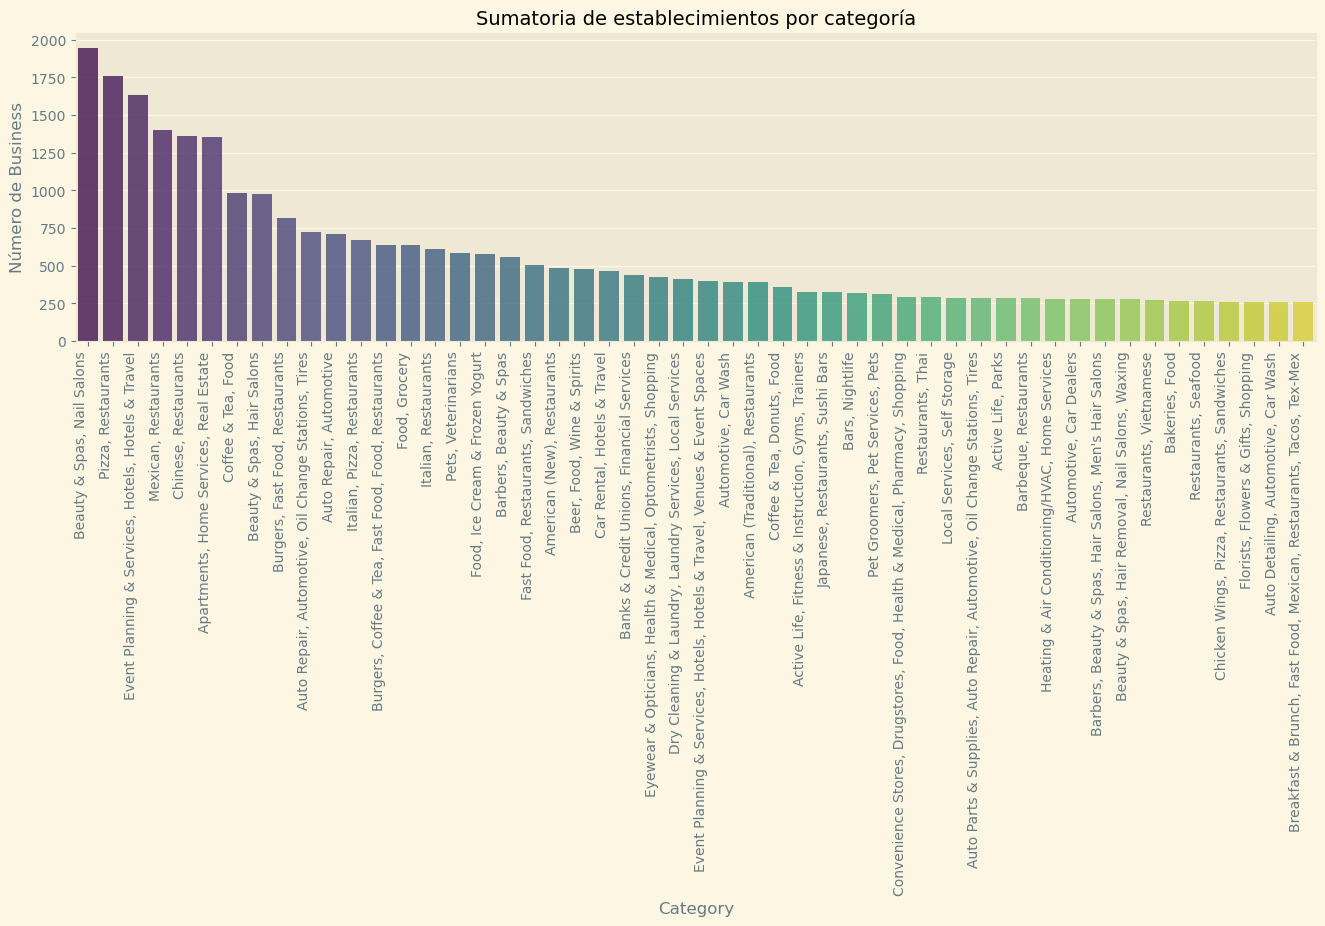

Total establecimientos: 28640 de 150346
La operación fue exitosa en 0.86seg
--------------------------------------------------

Resultado de la agrupación, total (50, 2)


In [15]:
start_time=time.time()
try:
    #Agrupación por la categoría
    max_categorias_business = 50
    df_count_categories_business_pl = df_data_business_pl.group_by("categories").agg(
        pl.len().alias("count")  # pl.count() cuenta las filas en cada grupo
    ).sort("count", descending=True)
    df_count_categories_business_pl = df_count_categories_business_pl.limit(max_categorias_business)
    df_category_counts_pd = df_count_categories_business_pl.to_pandas()
    plt.figure(figsize=(16,4))
    sns.barplot(x='categories', y='count',data=df_category_counts_pd, alpha=0.8, palette='viridis',hue='categories')
    plt.title("Sumatoria de establecimientos por categoría",fontsize=14)
    plt.xticks(rotation=90, ha='right')
    plt.ylabel('Número de Business', fontsize=12)
    plt.xlabel('Category', fontsize=12)
    plt.show()
    print(f'Total establecimientos: {df_category_counts_pd['count'].sum()} de {df_data_business_pl.shape[0]}')

except Exception as e:
    print(f"An error occurred: {e}")
else: 
    print(f"La operación fue exitosa en {time.time()-start_time:.2f}seg")  
    print("-" * 50 + "\n")
    # Ver el resultado
    print(f'Resultado de la agrupación, total {df_count_categories_business_pl.shape}')
    #display(df_count_categories_business_pl.head(5)) 
    df_count_categories_business_pl = None

#### Review - Reseñas

Para facilitar el análisis visual de los datos, agrego una nueva columna con la longitud del texto de la reseña del usuario.

In [8]:
start_time=time.time()
try: 
    print("-" * 50)
    df_data_review_pl = df_data_review_pl.with_columns(
        pl.col("text").str.len_chars().alias("length")
    ) 
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print(f"La operación fue exitosa en {time.time()-start_time:.2f}seg") 


--------------------------------------------------
La operación fue exitosa en 0.39seg


A continuación, observamos la distribución agrupadas por las estrellas del conjunto total de datos.

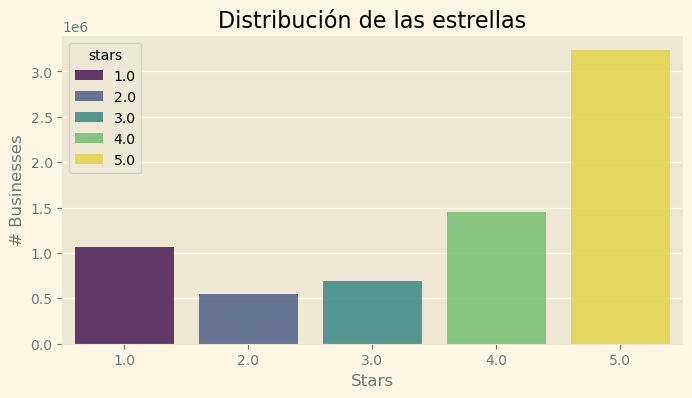

In [10]:
#Distribución grupal
x=df_data_review_pl['stars'].value_counts().sort('count', descending=True)
plt.figure(figsize=(8,4))
ax= sns.barplot(x='stars', y='count',data=x, alpha=0.8,hue='stars',palette='viridis')
plt.title("Distribución de las estrellas")
plt.ylabel('# Businesses', fontsize=12)
plt.xlabel('Stars', fontsize=12)
plt.show()

A continuación, observamos la distribución de la longitud de las reseñas agrupadas por las estrellas del conjunto total de datos.

__Nota:__ La ejecución del siguiente bloque de código requiere mucha memoria, podría Jupyter dar algún error.

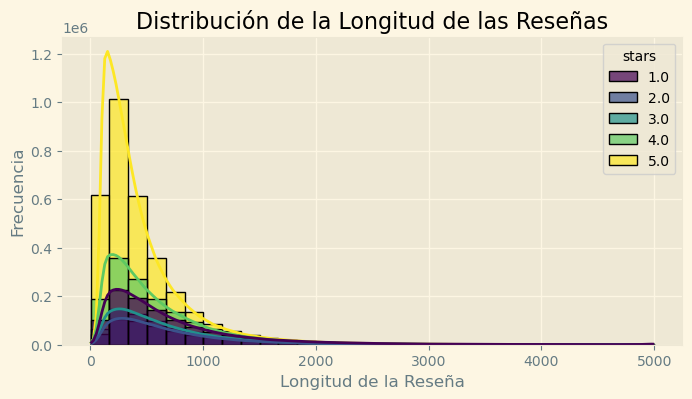

La operación fue exitosa en 46.12seg


In [9]:
start_time=time.time()
# Tamaño de la figura
plt.figure(figsize=(8, 4)) 

# Seaborn histplot
sns.histplot(data=df_data_review_pl.to_pandas(), 
                x='length',
                bins=30,
                palette='viridis', 
                hue='stars',
                edgecolor='black',
                alpha=0.7,
                kde=True
            )

# Añade títulos y etiquetas
plt.title('Distribución de la Longitud de las Reseñas', fontsize=16)
plt.xlabel('Longitud de la Reseña', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12) # histplot etiqueta automáticamente el eje Y como 'Count' o similar, pero puedes añadir o modificar con plt.ylabel

# Muestra el gráfico
plt.show()
print(f"La operación fue exitosa en {time.time()-start_time:.2f}seg") 

### Conclusión de la distribución de los datos

Tras realizar el análisis estructural y visual de los datos obtenemos la siguientes dos conclusiones:

__Conclusión estructural de datos__
    
Con la observación de las gráficas anteriores para la distribución de la cantidad de negocios agrupados por sus categorias y la distribución de la calificación por estrellas de cada negocio, vemos que las cantidades de reseñas y categorías de negocios varían:

*   Según las estrellas: hay muchas de 5 estrellas y comparativamente pocas de 2 o 3 estrellas.
*   Según la categoría de los negocios: hay muchas de la categoría "Beatuy and spas" en comparativa con las demás.

Si usaramos todos los datos tal cual, manejariamos la posibilidad que los modelos se vea dominado por las clases mayoritarias, debido a esto decidimos realizar una selección balanceada para las categorías y las reseñas, ejemplo: para las reseñas tomamos la misma cantidad de reseñas para cada puntuación, por ejemplo, el número de reseñas de la categoría más pequeña.  En el conjunto de datos de reseñas podría volverse muy bueno prediciendo reseñas de 5 estrellas (simplemente porque son las más comunes), pero muy malo entendiendo o prediciendo las de 2 o 3 estrellas, porque "aprende" a ignorarlas. Al balancear la muestra, cada reseña de cada categoría tendrá la misma oportunidad de ser representada y aprendida, lo que puede llevar a modelos con mejor rendimiento generalista para todas las reseñas.

__Conclusión visual de datos__

El análisis del gráfico de distribución revela que la gran mayoría de las reseñas, sin importar su calificación son relativamente cortas. La frecuencia más alta se concentra en longitudes muy reducidas donde el pico principal se sitúa más o menos por debajo de los 500 caracteres y disminuye rápidamente a medida que las reseñas se alargan.  Además, se observa que las reseñas de 4 y 5 estrellas (verde y amarillo) no solo son las más numerosas en general, sino que también dominan en las longitudes más cortas, y las reseñas de 1 y 2 estrellas (morado y azul), aunque también mayoritariamente cortas, presentan una frecuencia general considerablemente menor. Si bien su frecuencia es baja, la presencia de reseñas de todas las calificaciones se extiende hacia longitudes mayores.

Considerando la longitud para usos posteriores, las reseñas muy largas podrían contener más detalles contextuales, pero también arriesgan incluir información superflua o "ruido" (anécdotas, repeticiones) que dificulte la identificación de patrones claves. Por otro lado, reseñas extremadamente cortas (ej. "¡Genial!") carecen de información suficiente para un análisis significativo.

Por ello, y buscando un equilibrio entre la obtención de suficiente contexto y la minimización del ruido, se ha decidido seleccionar un segmento de reseñas con una longitud mínima de 256 y máxima de 512 caracteres. Este rango busca excluir las reseñas más breves y potencialmente menos informativas, así como las excesivamente largas, centrándose en un espectro donde se espera encontrar un balance más útil y claridad para el análisis.

Centrandonos ahora en las categorías y en la representación visual de los tipos de negocios más comunes y populares en el dataset, vemos que en la de mayor representación podría ser ser donde probablemente se concentra la mayoría de las reseñas e interacciones.  Se ve que hay unas pocas categorías con muchísimos negocios (la "cabeza" de la distribución) y luego una gran cantidad de categorías con un número de negocios progresivamente menor (la "larga cola").  En línea con la selección de las tipologías y en como los datos tienen a tener una distribución más omogenea, es por ello que haremos una selección de las primeras 32 tipologías.

### Selección de los datos
Tras las conclusiones anteriores damos inicio a los siguientes pasos:

1.  Selección de los 32 primeros negocios con mayor representación, además con el objetivo de obtener un selección equilibrada de los datos usaremos la categoría con menor representación para así mismo hacer el la selección de las demás.
2.  De la selección anterior de negocios haremos la selección de cada una de sus reseñas y buscaremos obtener una selección equilibrada entre la cantidad y estrellas de las reseñas.
3.  Seguidamente filtraremos de la selección de las reseñas, solo aquellas que tengan una longitud mayor a 256 y menor a 512 caracteres.
4.  Finalmente, añadiremos al dataset de datos seleccionados las columnas más relevantes del dataset de usuarios.

Durante las pruebas iniciales con Bert, observamos que el usar solo el texto de las reseñas da como resultado tasas de evaluación no aceptables, por consiguiente, decidimos incorporar metainformación adicional a las reseñas para expandir el corpus de entrenamiento y así mejorar la exactitud del modelo:

*   Del dataset business, seleccionamos los campos review_count y stars.
*   Del dataset user, seleccionamos los campos average_stars y review_count.

#### 1. Selección de establecimientos - business
A continuación, de los 32 tipos de negocios con mayor representación y con el objetivo de obtener una selección equilibrada de los datos, usaremos la categoría con menor representación como base para realizar la selección de las demás.

In [16]:
start_time=time.time()
try:
    #Agrupación por la categoría
    target_col_name = 'categories'
    seed = 42 # Para reproducibilidad
    max_categorias_business = 32
    df_count_categories_business_pl = df_data_business_pl.group_by(target_col_name).agg(
        pl.len().alias("count")  # pl.count() cuenta las filas en cada grupo
    ).sort("count", descending=True)
    # Limitar a las 32 primeras categorias más representadas
    df_count_categories_business_pl = df_count_categories_business_pl.limit(max_categorias_business)
    # Filtrar y seleccionar del dataset total solo las categorías seleccionadas
    df_filter_bussiness_limited = df_data_business_pl.filter(
        pl.col(target_col_name).is_in(df_count_categories_business_pl[target_col_name])
    )
    # Calcular tamaño de clase minoritaria ---
    # Encuentra el número de muestras en la clase más pequeña
    minority_size = df_count_categories_business_pl['count'].min()
    print(f"\nTamaño objetivo por clase (tamaño minoritario): {minority_size}")
    # Realizar Undersampling directamente en Polars ---
    print(f"\nAplicando Random Undersampling en Polars para la columna '{target_col_name}'")
    sampled_partitions = [] # Lista para guardar los DataFrames muestreados
    # Obtiene la lista de todas las clases únicas presentes
    all_classes = df_count_categories_business_pl[target_col_name].to_list()
    
    for class_value in all_classes:
        # Filtra el DataFrame para la clase actual
        partition = df_data_business_pl.filter(pl.col(target_col_name) == class_value)
        current_size = partition.height

        # Si la partición es más grande que el tamaño minoritario, la muestreamos
        if current_size > minority_size:
            sampled_partition = partition.sample(n=minority_size, with_replacement=False, shuffle=False, seed=seed)
            # print(f" - Clase '{class_value}': Reducida de {current_size} a {minority_size} muestras.")
        else:
            sampled_partition = partition
            # print(f" - Clase '{class_value}': Mantenida con {current_size} muestras.")

        sampled_partitions.append(sampled_partition)

    # Une todas las particiones (muestreadas o completas) verticalmente
    df_undersampled = pl.concat(sampled_partitions)

    # Mezclar las clases
    df_undersampled = df_undersampled.sample(fraction=1.0, shuffle=True, seed=seed)

    # Verificar el resultado ---
    print(f"Dimensiones remuestreadas: {df_undersampled.shape}")

    # Verifica la nueva distribución de clases
    final_counts = df_undersampled[target_col_name].value_counts().sort(by=target_col_name)
    # print(f"\nNueva distribución de '{target_col_name}':\n{final_counts}")

    # print(f"\nDataFrame Remuestreado (primeras 5 filas):\n{df_undersampled.head()}")

    df_final_filter_bussiness_limited_pl = df_undersampled.select(
            [
                pl.col('business_id'),                
                pl.col('review_count').alias('review_count_business'),
                pl.col('stars').alias('stars_business'),
                pl.col('categories')
            ]
        )

except Exception as e:
    print(f"An error occurred: {e}")
else: 
    print(f"La operación fue exitosa en {time.time()-start_time:.2f}seg")  
    print("-" * 50 + "\n")
    # Ver el resultado
    df_count_categories_business_pl = None
    df_filter_bussiness_limited = None
    df_undersampled = None
    print(f'Total establecimientos: {final_counts['count'].sum()} de {df_data_business_pl.shape[0]}')
    final_counts = None


Tamaño objetivo por clase (tamaño minoritario): 322

Aplicando Random Undersampling en Polars para la columna 'categories'
Dimensiones remuestreadas: (10304, 14)
La operación fue exitosa en 1.28seg
--------------------------------------------------

Total establecimientos: 10304 de 150346


In [17]:
print("Distribución original de estrellas:")
display(df_final_filter_bussiness_limited_pl[target_col_name].value_counts().sort(target_col_name))

Distribución original de estrellas:


categories,count
str,u32
"""Active Life, Fitness & Instruc…",322
"""American (New), Restaurants""",322
"""American (Traditional), Restau…",322
"""Apartments, Home Services, Rea…",322
"""Auto Repair, Automotive""",322
…,…
"""Italian, Restaurants""",322
"""Japanese, Restaurants, Sushi B…",322
"""Mexican, Restaurants""",322


#### 2. Selección de las reseñas - reviews
A partir de los negocios seleccionados previamente, escogeremos sus reseñas buscando obtener una muestra equilibrada tanto en cantidad como en la calificación por estrellas.

In [18]:
# 1. Seleccionar todas las reseñas de los negocios seleccionados
start_time=time.time()
try: 
    
    # Seleccionamos todas las reseñas de todos los negocios seleccionados
    df_business_reviews_filter_pl = df_data_review_pl.join(
        df_final_filter_bussiness_limited_pl,
        on='business_id', # La columna común para la unión
        how='inner'      # Tipo de join: inner (solo filas con coincidencias en ambos)
    )
except Exception as e:
    print(f"An error occurred: {e}")
else: 
    print(f"La operación fue exitosa en {time.time()-start_time:.2f}seg") 
    print("-" * 50 + "\n")
    print(f'Total reseñas: {len(df_business_reviews_filter_pl)} de {len(df_data_review_pl)}')

La operación fue exitosa en 0.62seg
--------------------------------------------------

Total reseñas: 344747 de 6990280


In [19]:
start_time=time.time()
try:
    print("Distribución original de las estrellas de los negocios seleccionados:")
    display(df_business_reviews_filter_pl['stars'].value_counts().sort('stars'))
except Exception as e:
    print(f"An error occurred: {e}")
else: 
    print(f"La operación fue exitosa en {time.time()-start_time:.2f}seg") 


Distribución original de las estrellas de los negocios seleccionados:


stars,count
f64,u32
1.0,74012
2.0,31263
3.0,34644
4.0,68097
5.0,136731


La operación fue exitosa en 0.01seg


In [20]:
start_time=time.time()
try:
    # Calcular el tamaño mínimo de grupo ---
    min_count = df_business_reviews_filter_pl.group_by("stars").agg(
            pl.len().alias("count")
        ).min().get_column('count')[0]
    print(f"\nEl grupo más pequeño tiene {min_count} reseñas.")
    print(f"Tomaremos {min_count} muestras de cada categoría de estrellas.")

    # Realizar el muestreo
    if min_count > 0:
        # Añadimos una columna con valores aleatorios para poder ordenar y tomar los 'primeros' N
        # Luego obtener una muestra aleatoria por grupo
        df_balanced = (
            df_business_reviews_filter_pl.with_columns(
                pl.lit(np.random.rand(len(df_business_reviews_filter_pl))).alias("random_sort_key")
            )
            .sort("random_sort_key") # Ordena aleatoriamente todo el DataFrame
            .group_by("stars", maintain_order=True) # Agrupa por estrellas, manteniendo el orden aleatorio dentro del grupo
            .head(min_count) # Toma las primeras 'min_count' filas de cada grupo (que ahora son aleatorias)
            .drop("random_sort_key") # Elimina la columna auxiliar
        )

        print("\nDistribución final de las estrellas en el DataFrame balanceado:")
        display(df_balanced['stars'].value_counts().sort('stars'))

        # Mezclar las clases
        df_business_reviews_pl = df_balanced.sample(fraction=1.0, shuffle=True, seed=seed)

    else:
        print("\nNo se puede crear una muestra balanceada porque al menos un grupo no tiene reseñas.")

except Exception as e:
    print(f"An error occurred: {e}")
else: 
    print(f"La operación fue exitosa en {time.time()-start_time:.2f}seg") 
    print("-" * 50 + "\n")
    print(f'Total reseñas: {len(df_business_reviews_pl)} e inicialmente eran {len(df_business_reviews_filter_pl)} de un total de {len(df_data_review_pl)}')
    df_balanced = None


El grupo más pequeño tiene 31263 reseñas.
Tomaremos 31263 muestras de cada categoría de estrellas.

Distribución final de las estrellas en el DataFrame balanceado:


stars,count
f64,u32
1.0,31263
2.0,31263
3.0,31263
4.0,31263
5.0,31263


La operación fue exitosa en 0.16seg
--------------------------------------------------

Total reseñas: 156315 e inicialmente eran 344747 de un total de 6990280


#### 3. Selección de las reseñas por longitud
A continuación, de las reseñas seleccionadas, conservaremos únicamente aquellas cuya longitud sea superior a 256 caracteres e inferior a 512.

In [21]:
start_time=time.time()
try: 
    filter_reviews_min_lenght = 256
    filter_reviews_max_lenght = 512
    df_business_reviews_lenght_pl = df_business_reviews_pl.filter(
       (pl.col("length") >= filter_reviews_min_lenght) & (pl.col("length") <= filter_reviews_max_lenght)
    ).sort('length', descending=False).limit(17000)
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print(f"La operación fue exitosa en {time.time()-start_time:.2f}seg")
    print(f'Total reseñas seleccionadas {df_business_reviews_lenght_pl.shape[0]} con una longitud en el texto superior a {filter_reviews_min_lenght} y menor a {filter_reviews_max_lenght} de un total base de {len(df_business_reviews_pl)}')    



La operación fue exitosa en 0.04seg
Total reseñas seleccionadas 17000 con una longitud en el texto superior a 256 y menor a 512 de un total base de 156315


Dentro del conjunto de datos seleccionado, observamos a continuación como se distribuyen las reseñas según la estrella asignada.

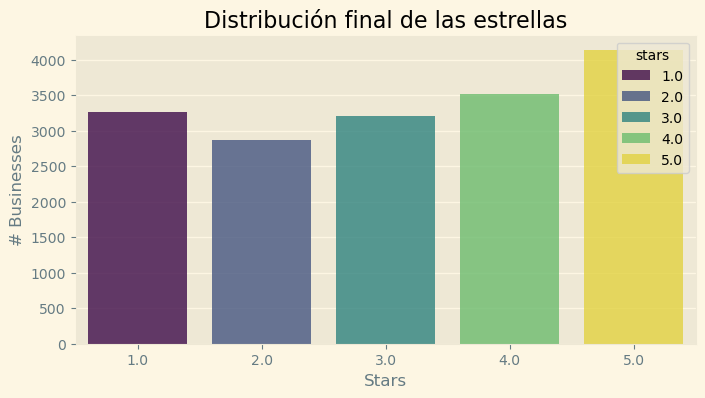

In [ ]:
#Distribución grupal
x=df_business_reviews_lenght_pl['stars'].value_counts().sort('count', descending=True)
plt.figure(figsize=(8,4))
ax= sns.barplot(x='stars', y='count',data=x, alpha=0.8,hue='stars',palette='viridis')
plt.title("Distribución final de las estrellas")
plt.ylabel('# Businesses', fontsize=12)
plt.xlabel('Stars', fontsize=12)
plt.show()

#### 4. Selección de información de usuarios
Finalmente, añadiremos al dataset de datos seleccionados las columnas más relevantes del dataset de usuarios.

In [22]:
df_business_reviews_lenght_pl

stars,review_id,user_id,business_id,useful,funny,cool,text,date,length,review_count_business,stars_business,categories
f64,str,str,str,i64,i64,i64,str,str,u32,i64,f64,str
2.0,"""cbbhg9YFMOzYzJXhpxriIA""","""8PLY0GHBspTA6IUDlVhymQ""","""EKbb62ui8LgHk3B7OJMyBw""",1,0,0,"""Wait staff is friendly and att…","""2013-08-01 17:51:56""",256,235,3.5,"""Japanese, Restaurants, Sushi B…"
2.0,"""ZkfwGb4Mbap8E0g51WwTnA""","""hzLimn8MwLz14RwxM20Nyg""","""5kZtETKu37RuwHATrB4a5g""",1,0,0,"""Sadly the management has moved…","""2019-06-11 12:24:27""",256,193,3.5,"""Active Life, Fitness & Instruc…"
4.0,"""tZrjYRubF7XIeFaUrMDohw""","""GPowooSv9cI3jhOoxPIuUQ""","""DxQ0ewGVhYHkNgu2gOSuZg""",0,0,0,"""Just another rental car place,…","""2013-09-05 20:31:34""",256,20,3.5,"""Car Rental, Hotels & Travel"""
5.0,"""iu7xPNyDm7IMuGSNtn96KA""","""BXkk4Z5ZqGN4R-IuV7Oi3Q""","""g4WzNohp7YOYv6-MEJiZJA""",0,0,0,"""Absolutely remarkable experien…","""2020-08-30 01:40:53""",256,37,5.0,"""Japanese, Restaurants, Sushi B…"
5.0,"""2CE2cg-CxL9SowbN4LWuQw""","""BLIuKUclBOYdnet15Mj-qw""","""MdqvcsCUSig-0ga4ioxn7g""",0,0,0,"""Just got takeout here tonight …","""2020-04-05 00:38:30""",256,125,4.0,"""Mexican, Restaurants"""
…,…,…,…,…,…,…,…,…,…,…,…,…
5.0,"""BxY0kbXV4OPSJDmV0YspXg""","""dNS9DllfQwRBFjiVAaG9dQ""","""6JFMbFYVbl8ufz74NSDgOA""",1,0,0,"""This is one of my favorite res…","""2011-01-16 04:33:17""",334,147,4.0,"""American (New), Restaurants"""
1.0,"""h5ZtKLdoW4vf8TLXnnS8aQ""","""64hOb5iYHbW0C8a9KZEEIA""","""hb4Viui0dPDUpFqN1PbRKA""",2,1,0,"""I've been waiting over 25 minu…","""2013-08-21 18:57:19""",334,359,2.0,"""Car Rental, Hotels & Travel"""
4.0,"""GKayaDpLaRSCoDz9-D2A9w""","""cMRblmKjK5KYICWJey4bGA""","""SYKy8Y_zDlsDuBoZsAckig""",1,0,0,"""I was a bit concerned after re…","""2011-01-12 20:51:03""",334,24,3.0,"""Italian, Restaurants"""


In [24]:
# 1. Seleccionar todas las reseñas de los negocios seleccionados
start_time=time.time()
try: 
    df_user_columns_filter = df_data_user_pl.collect(engine='streaming').select(
        [
            pl.col('user_id'),                
            pl.col('review_count').alias('review_count_user'),
            pl.col('average_stars').alias('average_stars_user')
        ]
    )
    # Seleccionamos todas las reseñas de todos los negocios seleccionados
    df_final_data_selected_pl = df_business_reviews_lenght_pl.join(
            df_user_columns_filter,
            on='user_id', # La columna común para la unión
            how='inner'      # Tipo de join: inner (solo filas con coincidencias en ambos)
        ).select(
            [
                pl.col('review_id'),                
                pl.col('user_id'),
                pl.col('business_id'),
                pl.col('text'),
                pl.col('stars'),
                pl.col('categories'),
                pl.col('review_count_business'),
                pl.col('stars_business'),                
                pl.col('review_count_user'),
                pl.col('average_stars_user')
            ]
        )
except Exception as e:
    print(f"An error occurred: {e}")
else: 
    print(f"La operación fue exitosa en {time.time()-start_time:.2f}seg") 
    print("-" * 50 + "\n")
    print(f'Total reseñas: {len(df_final_data_selected_pl)}')
    display(df_final_data_selected_pl)


# df_business_reviews_lenght_pl

La operación fue exitosa en 1.99seg
--------------------------------------------------

Total reseñas: 17000


review_id,user_id,business_id,text,stars,categories,review_count_business,stars_business,review_count_user,average_stars_user
str,str,str,str,f64,str,i64,f64,i64,f64
"""YkbKQcSDQAMJm0WboUBOLA""","""IpLRJY4CP3fXtlEd8Y4GFQ""","""34-i9B0d0r0575-x6xDTsw""","""This place is nothing special.…",2.0,"""Italian, Restaurants""",129,3.0,518,2.95
"""ax4u663sjF4UprVDSET_ZA""","""qsHZ6_yT870pmm4Oxvw5Og""","""-kX4WpZWN_6Xp2mVsYoKVg""","""I LOVE the zumba classes - how…",2.0,"""Active Life, Fitness & Instruc…",86,2.5,39,3.85
"""SNZ8fisexqrqAhwOTzBQlA""","""asAdx4Q3cAMykgPgtQt6cg""","""lzd8C9rmc4_5tmmnbq_7Lw""","""This is a Mid West style thin …",4.0,"""Pizza, Restaurants""",126,4.0,123,4.2
"""XSGA_Yc0NaWgoLkHU3RU2g""","""PZE8NFD4XYMejKLFJm47bw""","""4CBk3DBUgl3V9zbVBKsIqQ""","""So good! ..and more of an auth…",4.0,"""Japanese, Restaurants, Sushi B…",40,3.0,38,3.85
"""QB5S75wI435hUSBWeEp19w""","""KrIL3TIOJI-tjvU6BlcA-g""","""PXNIcWp4xqtXllJlLseO3g""","""Dr. Toscani and her assistants…",4.0,"""Eyewear & Opticians, Health & …",65,4.0,141,4.22
…,…,…,…,…,…,…,…,…,…
"""PFxN2Z6gMJI3QMWFoxnlEw""","""TMgKNKrDtMParQZ9_0udeA""","""2xvxGJu9rWdhZ7AheiOheQ""","""God!!!! I am make fries faster…",1.0,"""Burgers, Coffee & Tea, Fast Fo…",59,1.5,5,3.2
"""KaZcbMIhosvYGJwL10_3tg""","""q-9tQtcQ7ZGh5S_xHamZfw""","""8NSzJSdgt1IMkTdA2Cf65g""","""Poor customer service. I had a…",1.0,"""Event Planning & Services, Hot…",233,4.0,1,1.0
"""DKBKY1dQUDGT7ypmI9JMzA""","""LqcH2Jef8gvx6m2I5OVaRw""","""3WTB4ngzQ31QPJOcH21NCg""","""My first impression when enter…",5.0,"""Event Planning & Services, Hot…",22,3.5,4,3.0


### Guardar las reseñas seleccionadas

In [25]:
# Guardar este DataFrame como archivo jsonl
try:
    review_selected_file_path = f'{explicit_work_path}yelp_academic_dataset_review_selected.jsonl'
    df_final_data_selected_pl.write_json(review_selected_file_path)
except Exception as e:
    print(f"Error al guardar jsonl: {e}")
else:
    print('Fichero seleccionados guardado en JSONL')

Fichero seleccionados guardado en JSONL


In [26]:
# Guardar como Arrow IPC
try:
    review_selected_file_path = f'{explicit_work_path}yelp_academic_dataset_review_selected.arrow'
    df_final_data_selected_pl.write_ipc(review_selected_file_path, compression='zstd')    
except Exception as e:
    print(f"Error al guardar IPC: {e}")
else:
    print('Fichero seleccionados guardado en IPC')

Fichero seleccionados guardado en IPC


In [27]:
# Guardar como CSV
try:
    review_selected_file_path = f'{explicit_work_path}yelp_academic_dataset_review_selected.csv'
    df_final_data_selected_pl.write_csv(review_selected_file_path)    
except Exception as e:
    print(f"Error al guardar CSV: {e}")
else:
    print('Fichero seleccionados guardado en CSV')

Fichero seleccionados guardado en CSV


### Descarga de kaggle

Para facilitar el acceso a las reseñas seleccionadas fueron subidas a Kaggle.

In [ ]:
#path = kagglehub.dataset_download("aagudelom/reviews-dataset")
#print("Path to dataset files:", path)

# Información de sesión

In [ ]:
import session_info
session_info.show(html=False)

-----
dotenv              NA
kagglehub           0.2.7
matplotlib          3.10.0
numpy               2.0.1
openai              1.76.2
pandas              2.2.3
polars              1.27.1
pyarrow             16.1.0
seaborn             0.13.2
session_info        v1.0.1
-----
IPython             9.1.0
jupyter_client      8.6.3
jupyter_core        5.7.2
jupyterlab          4.3.4
notebook            7.3.2
-----
Python 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:50:58) [GCC 12.3.0]
Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2025-05-02 23:54


# Instalación librerías

!conda create --name tfm python=3.12.2

!conda activate tfm

!conda install -y anaconda::jupyter

!conda install -y conda-forge::polars=1.27.1

!conda install -y anaconda::pandas=2.2.3

!conda install -y seaborn=0.13.2

!conda install -y matplotlib=3.10.0

!conda install -c conda-forge pyarrow=16.1.0

!conda install -y conda-forge::python-dotenv-with-cli

!conda install -y conda-forge::openai=1.75.0

!conda install -y conda-forge::kaggle

!conda install -y anaconda::kagglehub

!pip install session_info

!conda install -y conda-forge::imbalanced-learn

# Total ejecución del notebook

In [ ]:
print(f'Total ejecución {time.time() - start_time_global:.2f} segundos')

Total ejecución 116.85 segundos
